## 1. Importación y autenticación

In [11]:
#pip install earthengine-api
#!pip install geemap


In [19]:
import ee  # Acceso y procesamiento de datos en Google Earth Engine
import numpy as np # Cálculos numéricos (e.g., regresión)
import pandas as pd # Manejo de datos tabulares (NDVI, precipitación, residuos)
import matplotlib.pyplot as plt  # Visualización en gráficos
import matplotlib.colors as mcolors  # Manejo de mapas de color personalizados
import matplotlib.ticker as mticker # Formato de ejes (e.g., años)
from matplotlib.colorbar import ColorbarBase  # Para crear barras de color manualmente
import requests  # Para hacer peticiones HTTP (usado para obtener imágenes desde EE)
from PIL import Image  # Para manipular imágenes
from io import BytesIO  # Para convertir respuesta en imagen

1. Importa librerías estándar (numpy, pandas) y de Google Earth Engine (ee).
2. Carga funciones personalizadas desde módulos internos del proyecto.
3. Autentica el acceso a Earth Engine.
4. Carga el área de interés (AOI) a partir de un ID de asset

In [4]:
from auth.gee_auth import autenticar_gee

from data.parametros import aoi_asset_id, modis_palette, wc_palette, years
from utils.display import (
    mostrar_imagen_ee,                # Visualiza imágenes de Earth Engine
    obtener_rango_fitted,             # Obtiene el rango de valores ajustados (LandTrendr)
    mostrar_landtrendr_fitted,        # Visualiza los resultados ajustados de LandTrendr
    mostrar_clustering                # Muestra los resultados del clustering
)
from utils.helpers import reproyectar_imagenes
from utils.processing import (
    annual_precip,                  # Calcula precipitación anual a partir de datos climáticos
    combinar_ndvi_precip,           # Combina NDVI con precipitación para análisis conjunto
    ejecutar_landtrendr,            # Ejecuta el algoritmo LandTrendr sobre series temporales
    extraer_fitted_stack,           # Extrae la capa ajustada (fitted) del resultado de LandTrendr
    calcular_residuos               # Calcula residuos entre el valor observado y ajustado (modelo vs realidad)
)
from utils.clustering import (
    sample_training_data,           # Muestra aleatoria de datos para entrenamiento del modelo
    entrenar_kmeans,                # Entrena el modelo K-means
    aplicar_clustering              # Aplica el clustering a los datos de entrada
)
from analysis.graficos import (
    graficar_ndvi_vs_precipitacion,  # Grafica la relación entre NDVI y precipitación
    mostrar_landtrendr_fitted        # (Repetida) Visualiza resultados ajustados de LandTrendr
)
autenticar_gee()

aoi = ee.FeatureCollection(aoi_asset_id) # Carga el Área de Interés (AOI) 


✅ Earth Engine ya estaba inicializado.


## 2. Cargar y mostrar imagen base MODIS (Land Cover)

1. Carga la imagen MODIS de cobertura terrestre de 2001.
2. Recorta al AOI.
3. Muestra el resultado con una paleta de colores.

**MODIS MCD12Q1 vs MOD13Q1**

**Características**

| **Atributo**             | **MCD12Q1 - Cobertura de Suelo**                        | **MOD13Q1 - Vegetación (NDVI/EVI)**                  |
|--------------------------|---------------------------------------------------------|------------------------------------------------------|
| Producto                 | Clasificación global de cobertura de suelo              | Índices de vegetación NDVI y EVI                     |
| Resolución Espacial      | 500 m a 1 km (según versión)                           | 250 m                                                |
| Resolución Temporal      | Anual                                                   | Cada 16 días                                         |
| Periodo Disponible       | Desde 2001 hasta la actualidad                         | Desde 2000 hasta la actualidad                      |
| Bandas/Variables         | `LC_Type1` a `LC_Type5` (Categorías de uso/cobertura)  | NDVI, EVI, Ángulos de visión, Calidad (QA)          |
| Cobertura Geográfica     | Global                                                  | Global                                               |
| Detección de Cambio      | Cambios anuales en el uso/cobertura del suelo           | Cambios estacionales o intra-anuales en la vegetación |

**Aplicaciones**

- **MCD12Q1**  
  Mapas de uso de suelo, cambio de cobertura, modelos ecológicos, análisis de flujos de carbono, dinámica de vegetación a gran escala.

- **MOD13Q1**  
  Monitoreo de vegetación, productividad primaria, estudios fenológicos, detección de sequías, dinámica estacional.

**Clasificación IGBP (`LC_Type1` - 17 Categorías)**

| **Banda**      | **Esquema**                          | **Descripción**                                                   |
|----------------|--------------------------------------|-------------------------------------------------------------------|
| `LC_Type1`     | IGBP (International Geosphere-Biosphere Programme) | Clasificación en 17 categorías globales, estándar más utilizado. |
| `LC_Type2`     | UMD (University of Maryland)         | Clasificación basada en tipos de vegetación y suelo, orientada a análisis regionales. |
| `LC_Type3`     | LAI/FPAR Biomes                     | Clasificación según biomas relevantes para índices de vegetación y producción primaria. |
| `LC_Type4`     | BGC (Biogeochemical Cycles)         | Categorías adaptadas a estudios de flujos de carbono y ciclos biogeoquímicos. |
| `LC_Type5`     | PFT (Plant Functional Types)        | Tipología funcional de la vegetación, útil para modelos dinámicos de vegetación. |

| **Clase** | **Color Hex** | **Descripción**                                          |
|------------|----------------|---------------------------------------------------------|
| 0          | `#05450a`      | Sin asignar                                             |
| 1          | `#086a10`      | Bosque de hoja perenne de coníferas                     |
| 2          | `#54a708`      | Bosque de hoja perenne de latifoliadas                  |
| 3          | `#78d203`      | Bosque de hoja caduca de coníferas                      |
| 4          | `#009900`      | Bosque de hoja caduca de latifoliadas                   |
| 5          | `#c6b044`      | Bosque mixto                                            |
| 6          | `#dcd159`      | Matorral cerrado                                        |
| 7          | `#dade48`      | Matorral abierto (leñosas 1-2 m, 10-60% cobertura)     |
| 8          | `#fbff13`     -

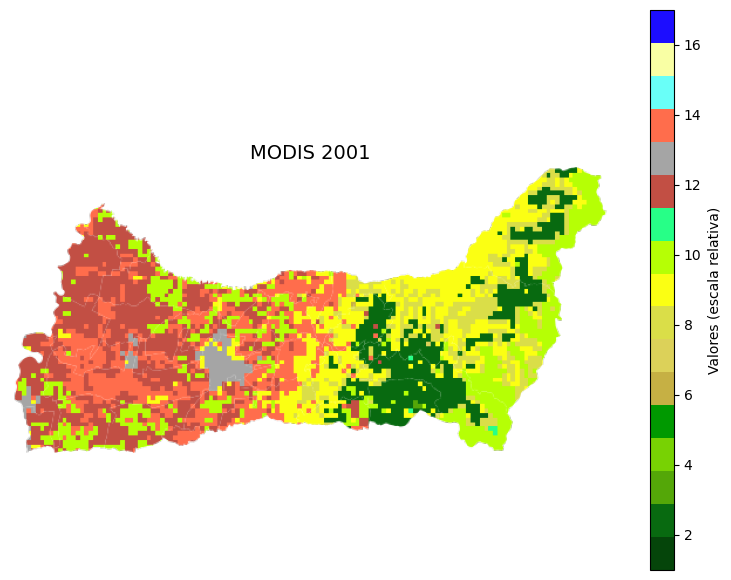

In [5]:
# Se obtiene la colección de imágenes MODIS de cobertura de tierra (Land Cover)
modis = ee.ImageCollection('MODIS/061/MCD12Q1') \
    .filterDate('2001-01-01', '2001-12-31') \
    .first() \
    .select('LC_Type1') \
    .clip(aoi)

mostrar_imagen_ee(
    imagen=modis,
    region=aoi,
    titulo="MODIS 2001",
    min_val=1,
    max_val=17,
    palette=modis_palette
)

## 3. Generar colección NDVI + precipitación y reproyectar

1. **Crea una colección anual de imágenes combinadas**, donde cada imagen representa un año y contiene dos variables clave:
   - **NDVI máximo anual**, obtenido de la colección [`MODIS/061/MOD13Q1`](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13Q1?hl=es-419) (resolución de 250 m).
   - **Precipitación acumulada anual**, derivada del conjunto [`UCSB-CHG/CHIRPS/DAILY`](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY?hl=es-419) (resolución de aproximadamente 5 km).

2. **Reproyecta la colección combinada** al sistema de referencia espacial del producto MODIS, asegurando una alineación espacial consistente entre las variables para permitir análisis temporales por píxel.

### **CHIRPS - Climate Hazards Group InfraRed Precipitation with Station Data**

**Resumen:**
- **Cobertura:** Cuasi-global (50°N a 50°S)
- **Resolución espacial:** 0.05° (~5 km)
- **Resolución temporal:** Diario, 10 días, Mensual
- **Período:** 1981 - Actualidad
- **Fuente:** Satélite + Estaciones meteorológicas
- **Acceso en Earth Engine:** `UCSB-CHG/CHIRPS/DAILY`

**Limitaciones:**
Menor precisión en zonas con pocas estaciones  
No cubre latitudes mayores a 50°  

**Otras**

| Producto       | Resolución | Período | Notas |
|----------------|------------|---------|-------|
| **GPM IMERG** | 0.1°, 30 min | 2000 - Actualidad | Alta resolución temporal, global 60°N-60°S |
| **PERSIANN-CDR** | 0.25°, Diario | 1983 - Actualidad | Series largas para estudios climáticos |
| **MSWEP** | 0.1°, Diario | 1979 - Actualidad | Combina estaciones, satélite y reanálisis |
| **ERA5 Reanalysis** | ~30 km, Horario | 1950 - Actualidad | Completo, incluye múltiples variables climáticas |

**¿Qué elegir?**

- **CHIRPS:** Estudios de sequía, agricultura, zonas tropicales  
- **GPM IMERG:** Eventos extremos, tormentas  
- **MSWEP / ERA5:** Modelado climático e hidrológico de largo plazo  

In [6]:
# Se crea una colección de imágenes combinadas (NDVI + precipitación) para cada año
combined_collection = ee.ImageCollection([
    combinar_ndvi_precip(year, aoi) for year in years  # Aplica la función de combinación por cada año definido
])

# Se obtiene la proyección espacial de la imagen MODIS como referencia
ref_proj = modis.projection()

# Reproyecta la colección combinada a la misma resolución y sistema de referencia que MODIS
combined_collection_repro = reproyectar_imagenes(combined_collection, ref_proj)


## 4. Mostrar imagen NDVI

Extrae y visualiza el NDVI para el año 2010.

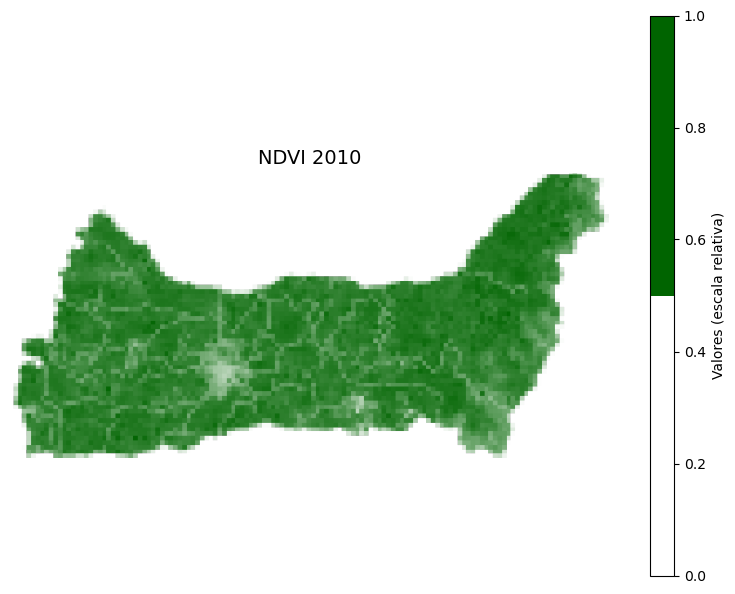

In [7]:
# Filtra la imagen correspondiente al año 2010 dentro de la colección reproyectada
img_2010 = combined_collection_repro.filter(ee.Filter.eq('year', 2010)).first()

# Muestra la banda de vegetación ('greenness') correspondiente al NDVI del año 2010
mostrar_imagen_ee(
    imagen=img_2010.select('greenness'),     # Selecciona solo la banda de verdor (NDVI)
    region=aoi,                              # Área de interés
    titulo="NDVI 2010",                      # Título del gráfico
    min_val=0,                               # Valor mínimo del NDVI
    max_val=1,                               # Valor máximo del NDVI
    palette=["ffffff", "006400"]             # Escala de color: blanco (bajo) a verde oscuro (alto)
)

## 5. Simulación de datos y gráfico NDVI vs Precipitación

En regiones áridas y semiáridas, como los pastizales o rangelands, la vegetación es altamente sensible a la variabilidad climática, especialmente a la precipitación anual. Esto significa que el NDVI (Normalized Difference Vegetation Index) —un indicador de productividad vegetal— puede fluctuar significativamente de un año a otro sin que haya ocurrido ningún cambio real en la cobertura del suelo.

1. Un año lluvioso puede aumentar drásticamente el NDVI, simulando una "mejora" del ecosistema.
2. Un año seco puede reducir el NDVI, aparentando una "degradación".
3. Estos cambios no necesariamente reflejan transformación real de uso del suelo, como deforestación, expansión agrícola, desertificación, etc.

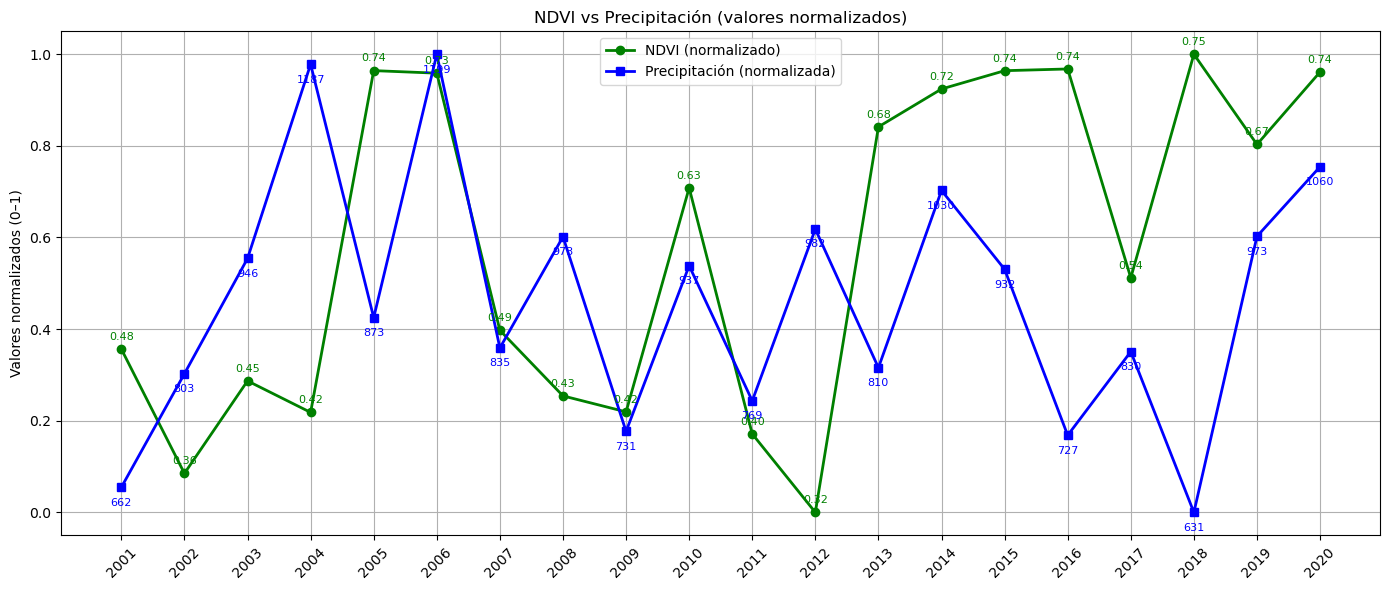

In [12]:
# Crea una lista de valores aleatorios de NDVI entre 0.3 y 0.8,
ndvi_values = np.random.uniform(0.3, 0.8, len(years))
precip_values = np.random.uniform(600, 1200, len(years))

# Crea un DataFrame con los años y los valores generados
df = pd.DataFrame({
    'Año': years,                      # Años definidos previamente
    'NDVI_promedio': ndvi_values,     # Valores simulados de NDVI promedio
    'Precipitacion_mm': precip_values # Valores simulados de precipitación anual
})

graficar_ndvi_vs_precipitacion(df)


## 6. LandTrendr sobre NDVI

Se aplica LandTrendr sobre NDVI para generar curvas ajustadas por píxel y visualizar cambios suaves en la vegetación.

1. **Detectar y modelar cambios en el tiempo**
El algoritmo LandTrendr (Landsat-based Detection of Trends in Disturbance and Recovery) segmenta series temporales en trayectorias simplificadas, identificando los puntos clave ("vértices") donde ocurre un cambio en la tendencia del índice (NDVI o residual).
- Permite modelar el comportamiento de cada píxel a lo largo del tiempo, reduciendo el ruido interanual.
- Facilita la identificación de eventos de cambio real (e.g., degradación, recuperación, aforestación), incluso si son graduales.

2. **Obtener una versión suavizada del NDVI o de los residuos**
- El resultado de LandTrendr no son los valores originales, sino los valores ajustados (“fitted”) de NDVI o residual, estimados mediante el modelo de segmentos lineales.
- Estos fitted values representan la trayectoria esperada o “filtrada” del cambio.
- Eliminan valores atípicos (outliers) o anomalías de corto plazo.

3. **Visualizar cómo ha evolucionado el paisaje**

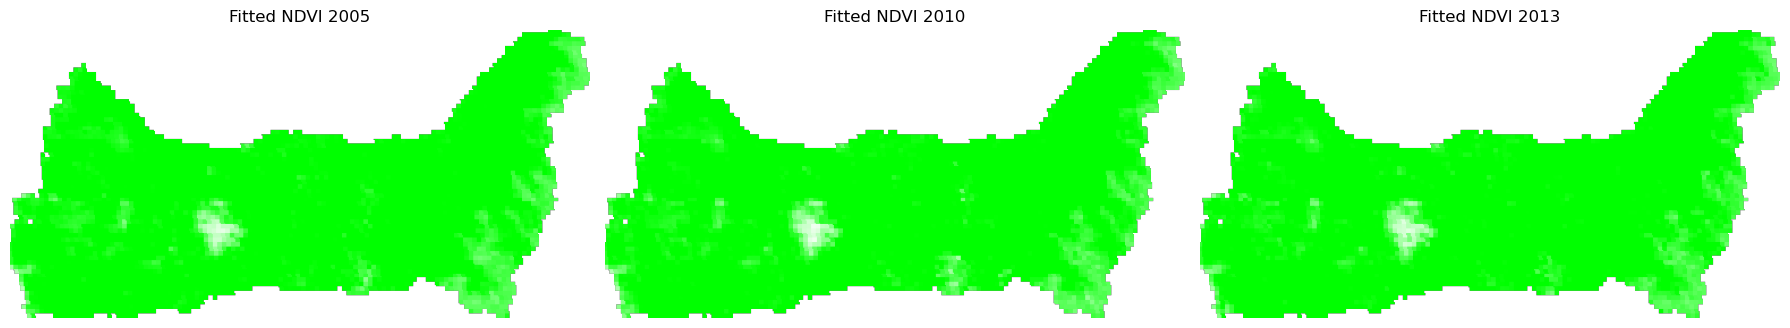

In [14]:
lt_output = ejecutar_landtrendr(combined_collection_repro)
fitted_stack = extraer_fitted_stack(lt_output, start_year=2001, num_years=20)

mostrar_landtrendr_fitted(
    fitted_stack,
    years=['2005', '2010', '2013'],
    aoi=aoi
)

## 7. Calcular residuos NDVI-precipitación

1. Calcula residuos de NDVI tras eliminar el efecto de la precipitación.
2. Visualiza la “productividad neta” corregida en 2010.

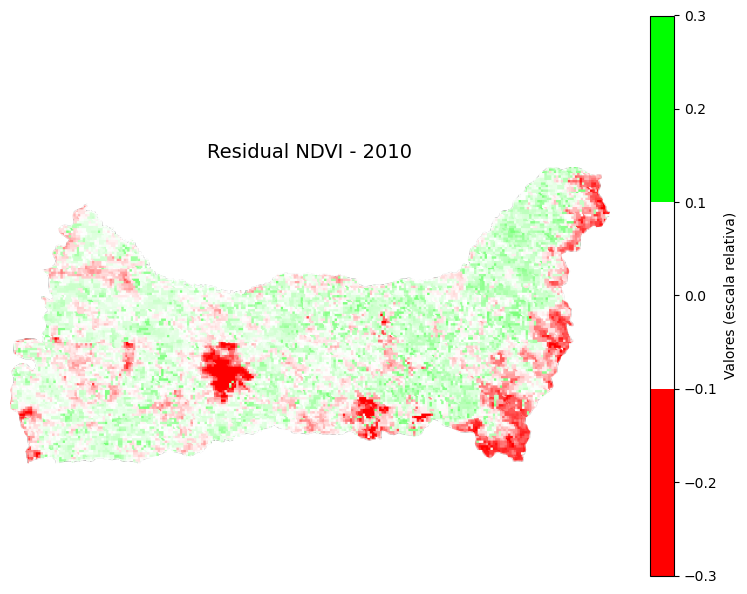

In [15]:
# Calcula los residuos para cada año en la colección original (NDVI observado - NDVI ajustado por LandTrendr)
residual_collection = calcular_residuos(combined_collection, aoi)

# Filtra la imagen de residuos correspondiente al año 2010
img_2010_residual = residual_collection.filter(ee.Filter.eq('year', 2010)).first()

# Visualiza los residuos del NDVI para 2010
mostrar_imagen_ee(
    imagen=img_2010_residual.select('residual'),  
    region=aoi,                                   
    titulo="Residual NDVI - 2010",                
    min_val=-0.3,                                 
    max_val=0.3,                                 
    palette=["ff0000", "ffffff", "00ff00"]        
)

## 8. LandTrendr sobre residuos

Este bloque permite detectar tendencias temporales en los errores (residuos) del modelo ajustado. Si los residuos tienen un patrón persistente en el tiempo (por ejemplo, siempre positivos en una zona), puede indicar:

1. Cambios reales que el modelo no capturó
2. Anomalías estructurales o consistentes
3. Áreas con comportamiento diferente al patrón general

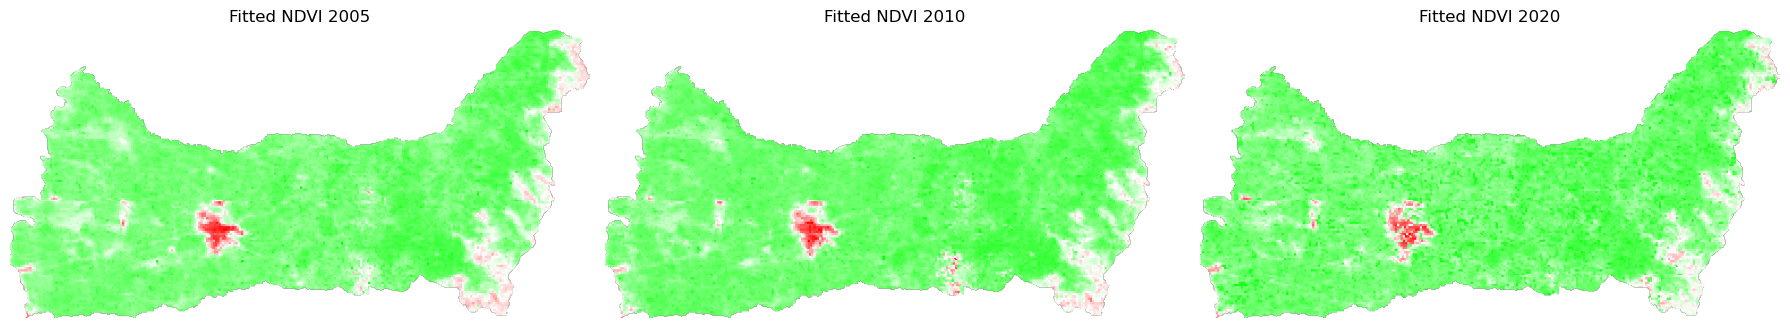

In [16]:
# 1. Ejecuta LandTrendr sobre la colección de residuos (residual NDVI)
# Esto permite analizar si hay tendencias sistemáticas en las diferencias entre lo observado y lo ajustado
lt_residual = ejecutar_landtrendr(residual_collection.select('residual'))

# 2. Extrae las bandas 'fitted' del resultado, una por cada año (2001 a 2020)
fitted_residual = extraer_fitted_stack(lt_residual, start_year=2001, num_years=20)

# 3. Define los años clave que se quieren visualizar
years_plot = ['2005', '2010', '2020']

# 4. Calcula el rango de valores (mínimo y máximo) para cada año seleccionado,
# usando solo los valores dentro del área de interés
rangos = obtener_rango_fitted(fitted_residual, years=years_plot, aoi=aoi)

# 5. Visualiza los mapas ajustados de residuos para los años seleccionados,
mostrar_landtrendr_fitted(
    fitted_residual,
    years=years_plot,
    aoi=aoi,
    rangos=rangos,
    palette=["ff0000", "ffffff", "00ff00"]
)

## 9. Clustering temporal basado en vértices de LandTrendr (residuos NDVI)

Este bloque usa el modelo de LandTrendr para capturar cambios en los residuos del NDVI, y luego aplica clustering sobre esos patrones temporales, permitiendo agrupar regiones con comportamientos similares no esperados.

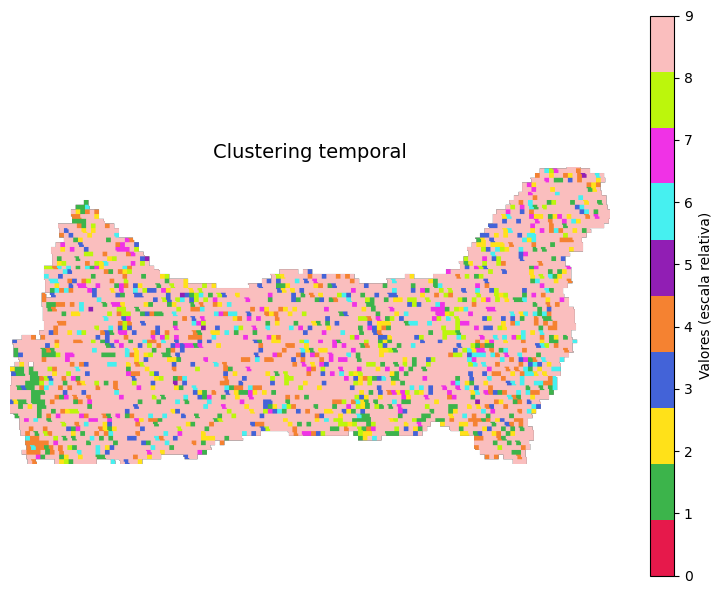

In [18]:
# 1. Crear vertex_stack correctamente proyectado
vertex_stack = lt_output.select('LandTrendr') \
    .arraySlice(0, 3, 4) \
    .arrayProject([1]) \
    .arrayFlatten([['vertex_year_' + str(y) for y in range(2001, 2021)]])
# 2. Muestra aleatoriamente puntos del área de interés con las bandas extraídas (para entrenamiento)
training_data = sample_training_data(vertex_stack, aoi)

# 3. Entrena un modelo K-means con los datos extraídos (sin supervisión)
kmeans_model = entrenar_kmeans(training_data, num_clusters=10)

# 4. Aplica el modelo a toda la imagen, generando una capa con 10 clases (clusters)
imagen_clusters = aplicar_clustering(vertex_stack, kmeans_model)

# 5. Visualiza el resultado del clustering en el área de estudio
mostrar_clustering(imagen_clusters, region=aoi, titulo="Clustering temporal")